# R3-Tool_HW



## 非程式題

請前往 https://mcp.so/ ，選擇一個 MCP Server，並回答以下問題：

1. 該 MCP Server 的名稱為何？
2. 它提供了哪些主要功能？
3. 你認為這些功能可以應用於哪些實際場景或解決哪些問題？

## 程式題
### baseline

使用 LangChain 的 Agent，註冊三個工具（查天氣、查時間、查匯率），讓 Agent 根據輸入自動選擇正確的工具來回答問題。

In [1]:
!pip install -q langchain langgraph transformers bitsandbytes langchain-huggingface langchain-community chromadb openai langchain_openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 70.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 65.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.1/438.1 kB 25.1 MB/s eta 0:0

In [4]:
from google.colab import userdata
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

In [9]:
from langchain.chat_models import ChatOpenAI
from langchain.agents import initialize_agent, AgentType
from langchain.tools import tool
import datetime

# ========== 自訂工具定義 ==========

# 使用 @tool 裝飾器定義可被 Agent 呼叫的工具
@tool
def get_weather(location: str) -> str:
  """查詢天氣"""
  return f"{location} 今天天氣晴，溫度約 25°C。"

@tool
def get_time(location: str) -> str:
  """查詢時間"""
  return f"{location} 現在時間是下午 3:00。"

@tool
def get_exchange_rate(currency: str) -> str:
  """查詢匯率"""
  if currency.upper() == "USD":
      return "1 USD = 31.25 TWD"
  elif currency.upper() == "JPY":
      return "1 JPY = 0.22 TWD"
  else:
      return f"{currency.upper()} 匯率資料暫無法提供"

llm = ChatOpenAI(model="gpt-4o-mini")

system_prompt = "請使用繁體中文回答所有問題。"

agent = initialize_agent(
    tools=[get_weather, get_time, get_exchange_rate],  # 將所有工具傳入
    llm=llm,
    agent=AgentType.OPENAI_FUNCTIONS,
    agent_kwargs={"system_message": system_prompt},  # 傳入 system prompt
    verbose=True  # 開啟詳細日誌
)

In [10]:
response = agent.run("我想知道台北的天氣、現在時間以及美元的匯率。")
print(response)




> Entering new AgentExecutor chain...

Invoking: `get_weather` with `{'location': '台北'}`


台北 今天天氣晴，溫度約 25°C。
Invoking: `get_time` with `{'location': '台北'}`


台北 現在時間是下午 3:00。
Invoking: `get_exchange_rate` with `{'currency': '美元'}`


美元 匯率資料暫無法提供台北今天天氣晴，溫度約 25°C。現在時間是下午 3:00。對於美元的匯率，我目前無法提供，抱歉造成不便。

> Finished chain.
台北今天天氣晴，溫度約 25°C。現在時間是下午 3:00。對於美元的匯率，我目前無法提供，抱歉造成不便。


## Advanced
使用LangGraph建立一個流程，由llm判斷問題是否與哆啦A夢道具相關，若有則使用RAG在資料庫裡找尋相關資料，若無則由模型自行回答問題。

Hint:參考流程圖

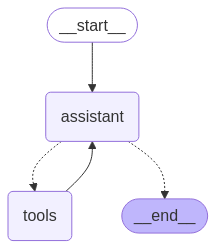

In [84]:
import os
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from langchain_core.documents import Document
from langchain.chat_models import ChatOpenAI
from langchain.tools import tool
from langgraph.graph import StateGraph, END

# 建立 Embedding + 向量資料庫
embedding_model = HuggingFaceEmbeddings(
    model_name="infgrad/stella-base-zh-v3-1792d",
    encode_kwargs={"normalize_embeddings": True}
)

docs_text = """
道具名稱	功能
引路天使	它可以告訴你最好的路，不至於在路上出意外。
雲朵凝固瓦斯	使用這個瓦斯的話，雲會凝固，變得可以奔走在雲上。
交換繩	兩人同時握住繩索的話，心還是一樣，但身體替換。
室內旅行機	可以顯示出各種地點的立體影像，但室內面積並不會隨之更動。會讓自己的家有旅行的味道。
落難神明	是一個難看老機器人。不過，幫助他的話，可以滿足3個請求。
南北極徽章	只要將自己與另外一個人貼上寫有「Ｎ」或「Ｓ」的徽章，就會變的像磁鐵一樣，同極相斥，異極相吸。
間諜工具組合	能用監視器看間諜人偶的「麥克風」和「」偵察的影像。
聲音糖果	只要利用這個錄製聲音，再給別人吃下去以後， 就可以得到被錄製聲音的特徵。
進化退化放射線槍	被這光照射到，動物就可以進化(或是退化)。
算了算了棒	用這個棒子將正在生氣的人的嘴巴堵住，並說「算了，算了」，那人氣就消了。
助興樂團	這兩個道具都是人型玩偶，都會播放音樂，讓氣氛變好；不同的是，只要讓小型插秧姑娘唱歌，就可以快速地完成插秧。
四次元口袋	哆啦A夢的道具都是放在這裡面的。四次元空間是個沒有大小的空間，要多大有多大。
美食桌巾	它可以幫你做出好吃的料理。無論甚麼料理都可以變出來。
愛神之箭	被箭射中的人，會對射箭的人產生好感。
感動麥克風	使用這個麥克風，發出的聲音就會讓人感動不已。
桃太郎丸子	讓動物吃下，他會對你言聽計從。
樵夫之泉	把東西丟到這個泉裡，女神就會出現。如果你說了實話，他就會給你一個更好、更新的東西。
更衣照相機	選擇合適的衣服，拍攝一下馬上就能穿在身上。
穿透環	可以穿過任何障礙。
如果電話亭	「如果這個世界是……」只要這樣對著話筒說話，就可以創造出你所說出的世界。但是當取消時，世界將會變成「平行世界」，雙方沒有瓜葛。
翻譯蒟蒻	吃了這個蒟蒻，任何人說的任何話，我們都可以聽懂、而且可以溝通。
縮小燈	被光照射到，東西會變小。
記憶麵包	只要吃下這個吐司，就能非常容易的記住事前寫在吐司上的事物。
時光布	包了的東西既可以變新，也可以變舊。
竹蜻蜓	是最常被哆啦A夢使用的道具！只要把它放置在身體任何部分，就可依自己意思在天空中翱翔。內藏超小型電池，可時速 80 公里連續飛行 8 小時。若是間斷飛行，還可撐更久！
時光機	除了時間移動之外，它也可以用來空間與空間間的互相移動。
任意門	只要心中想著想去的地點，電腦就會傳達並歪曲所在地與目的地間的空間而將兩地靠攏，跨過門就可以到達。但是不能去距離十光年以上的行星，或者是電腦地圖上沒有的地區。是很常用的道具，使用率位列第三，僅次於竹蜻蜓、時光機。

"""

lines = [line.strip() for line in docs_text.strip().split("\n")[1:] if line.strip()]
docs = []
for i in range(0, len(lines), 2):
  if i + 1 < len(lines):
      content = f"{lines[i]}\n{lines[i+1]}"
      docs.append(Document(page_content=content))

persist_path = "document_store"
if os.path.exists(persist_path):
  vectorstore = Chroma(persist_directory=persist_path, embedding_function=embedding_model)
else:
  vectorstore = Chroma.from_documents(docs, embedding_model, persist_directory=persist_path)
  vectorstore.persist()

#  LLM 模型
llm = ChatOpenAI(model="gpt-4o-mini")


Some weights of BertModel were not initialized from the model checkpoint at infgrad/stella-base-zh-v3-1792d and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [87]:
@tool
def doraemon_tool(query: str) -> str:
  """查詢哆啦A夢道具相關資料"""
  results = vectorstore.similarity_search(query, k=1)
  return results[0].page_content if results else "查無相關道具"

def is_doraemon_related(query: str) -> bool:
  prompt = f"請判斷這個問題是否與哆啦A夢道具相關。只回答「是」或「否」:{query}"
  result = llm.invoke(prompt).content.strip()
  return result.startswith("是")

In [88]:
from typing import TypedDict

class GraphState(TypedDict):
  query: str
  result: str

# 節點：判斷問題
def route_question(state: GraphState) -> str:
  query = state["query"]
  is_related = is_doraemon_related(query)
  route = "doraemon" if is_related else "general"
  print(f"路線判斷：{'哆啦A夢道具查詢' if is_related else '一般 LLM 回答'}")
  return route

# 節點：處理哆啦A夢問題
def handle_doraemon(state: GraphState) -> GraphState:
  response = doraemon_tool(state["query"])
  return {"query": state["query"], "result": response}

# 節點：處理一般問題
def handle_general(state: GraphState) -> GraphState:
  response = llm.invoke(state["query"]).content
  return {"query": state["query"], "result": response}

# LangGraph 圖形定義
workflow = StateGraph(GraphState)
workflow.add_node("doraemon", handle_doraemon)
workflow.add_node("general", handle_general)
workflow.set_conditional_entry_point(route_question)
workflow.add_edge("doraemon", END)
workflow.add_edge("general", END)

app = workflow.compile()


In [89]:
print("輸入你的問題（輸入 q 結束）：")
while True:
    query = input("使用者: ")
    if query.strip().lower() in ["q", "quit", "exit"]:
        break

    state = {"query": query}
    result = app.invoke(state)
    print("回答：", result["result"])
    print("=" * 60)

輸入你的問題（輸入 q 結束）：
使用者: 你知道哆啦a夢的任意門是做甚麼的嗎
路線判斷：哆啦A夢道具查詢
回答： 任意門	只要心中想著想去的地點，電腦就會傳達並歪曲所在地與目的地間的空間而將兩地靠攏，跨過門就可以到達。但是不能去距離十光年以上的行星，或者是電腦地圖上沒有的地區。是很常用的道具，使用率位列第三，僅次於竹蜻蜓、時光機。
使用者: 那 間諜工具組合 是甚麼
路線判斷：一般 LLM 回答
回答： 「間諜工具組合」通常指的是一系列用於情報收集、監控和滲透的工具或軟體，這些工具可能被政府機構、情報機構或黑客等使用。這些工具可能包括：

1. **監控軟體**：用於監聽通訊、記錄鍵盤輸入、截取螢幕等。
2. **漏洞利用工具**：用於利用系統或應用程序中的弱點，以獲取未經授權的訪問權限。
3. **社交工程工具**：用於通過操控人類行為來獲取敏感信息。
4. **數據分析軟體**：用於分析和處理大量數據，以提取有用的信息。
5. **偽裝工具**：用於隱藏身份或改變數據的真實性。

這些工具的使用通常涉及法律和道德問題，因此在許多國家和地區受到嚴格管制。
使用者: Q


## 衍生應用  
如果沒有提到 [哆啦A夢道具查詢]，  
我的 route_question 就會容易判別錯誤  
結合之前學過的history  
我想把最後一組對話紀錄在history裡面  

In [111]:
from typing import TypedDict, Optional
from langchain.chat_models import ChatOpenAI
from langchain.schema import SystemMessage,HumanMessage
from langchain.tools import tool
from langchain.vectorstores import Chroma
from langchain_core.documents import Document
class GraphState(TypedDict):
    query: str
    result: str
    route: str
    history: list[str]

# 判斷是否為哆啦A夢相關工具

def judge_tool(query: str, history: Optional[list[str]] = None) -> str:
  """判斷是否為哆啦A夢相關工具"""
  if history is None:
      history = []
  full_context = "\n".join(history + [f"使用者：{query}"])
  prompt = f"""
你是一個問題分類助手。請判斷最後一句使用者的問題，是否與「哆啦A夢的道具」有關。

請依據以下標準判斷：
- 若問題是詢問哆啦A夢中某個道具的「名稱、功能、用途、外觀、限制、原理」等，請回答「是」
- 若問題與哆啦A夢人物、劇情無關，或是屬於一般知識（如英文單字、數學問題、常識等），請回答「否」
- 如果不確定，也請保守回答「否」

---
對話內容如下：
{full_context}

請你只回覆「是」或「否」。
"""

  response = llm.invoke(prompt).content.strip()
  return response

# 哆啦A夢道具查詢工具
@tool
def doraemon_tool(query: str) -> str:
  """查詢哆啦A夢道具相關資料"""
  results = vectorstore.similarity_search(query, k=1)
  return results[0].page_content if results else "沒有找到相關的道具"


# 節點：判斷問題
def route_question(state: GraphState) -> str:
  query = state["query"]
  history = state.get("history", [])
  response = judge_tool(query=query, history=history)
  is_related = response.startswith("是")
  route = "doraemon" if is_related else "general"
  print(f"路線判斷：{'哆啦A夢道具查詢' if is_related else '一般 LLM 回答'}")
  return route

# 節點：處理一般問題
def handle_general(state: GraphState) -> GraphState:
  response = llm.invoke(state["query"]).content
  return {
      "query": state["query"],
      "result": response,
      "route": "general",
      "history": state.get("history", [])
  }
def handle_general(state: GraphState) -> GraphState:
    system_prompt = "請使用繁體中文回答所有問題。"
    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=state["query"])
    ]
    response = llm.invoke(messages).content
    return {
        "query": state["query"],
        "result": response,
        "route": "general",
        "history": state.get("history", [])
    }
# 節點：處理哆啦A夢問題（使用 tool）
def handle_doraemon(state: GraphState) -> GraphState:
  history = state.get("history", [])
  answer = doraemon_tool.invoke({"query": state["query"]})
  new_history = history + [f"使用者：{state['query']}"]
  return {
      "query": state["query"],
      "result": answer,
      "route": "doraemon",
      "history": new_history[-1:]  # 保留最近一次問題
  }

In [112]:
history = []
print("輸入你的問題（輸入 q 結束）：")
while True:
    query = input("使用者: ")
    if query.strip().lower() in ["q", "quit", "exit"]:
        break

    state = {"query": query, "result": "", "route": "", "history": history}
    route = route_question(state)
    if route == "doraemon":
        state = handle_doraemon(state)
    else:
        state = handle_general(state)

    # 更新歷史，只存使用者問題
    history = state["history"]

    print("回答：", state["result"])
    print("=" * 60)


輸入你的問題（輸入 q 結束）：
使用者: 你知道哆啦a夢的任意門是做甚麼的嗎
路線判斷：哆啦A夢道具查詢
回答： 任意門	只要心中想著想去的地點，電腦就會傳達並歪曲所在地與目的地間的空間而將兩地靠攏，跨過門就可以到達。但是不能去距離十光年以上的行星，或者是電腦地圖上沒有的地區。是很常用的道具，使用率位列第三，僅次於竹蜻蜓、時光機。
使用者: 那 間諜工具組合 是甚麼
路線判斷：哆啦A夢道具查詢
回答： 間諜工具組合	能用監視器看間諜人偶的「麥克風」和「」偵察的影像。
使用者: 紅茶的英文是甚麼
路線判斷：一般 LLM 回答
回答： 紅茶的英文是 "black tea"。
使用者: q


q :
你知道哆啦a夢的任意門是做甚麼的嗎  
那 間諜工具組合 是甚麼  
紅茶的英文是甚麼  

In [115]:
history = []
print("輸入你的問題（輸入 q 結束）：")
while True:
    query = input("使用者: ")
    if query.strip().lower() in ["q", "quit", "exit"]:
        break

    state = {"query": query, "result": "", "route": "", "history": history}
    route = route_question(state)
    if route == "doraemon":
        state = handle_doraemon(state)
    else:
        state = handle_general(state)

    # 更新歷史，只存使用者問題
    history = state["history"]

    print("回答：", state["result"])
    print("=" * 60)


輸入你的問題（輸入 q 結束）：
使用者: 你知道 多拉a夢嗎
路線判斷：一般 LLM 回答
回答： 知道的！《多啦A夢》是由藤本弘創作的漫畫和動畫，講述了一隻來自22世紀的機器貓——多啦A夢，回到過去幫助小學生野比大雄解決各種困難的故事。多啦A夢擁有各種神奇的道具，經常帶來幽默和感人的情節。這部作品在全球擁有大量的粉絲，也成為了日本文化的一部分。你對《多啦A夢》有什麼特別的問題或想法嗎？
使用者: 那任意門是他的道具嗎
路線判斷：哆啦A夢道具查詢
回答： 任意門	只要心中想著想去的地點，電腦就會傳達並歪曲所在地與目的地間的空間而將兩地靠攏，跨過門就可以到達。但是不能去距離十光年以上的行星，或者是電腦地圖上沒有的地區。是很常用的道具，使用率位列第三，僅次於竹蜻蜓、時光機。
使用者: 那有沒有推薦可以記憶的道具
路線判斷：哆啦A夢道具查詢
回答： 道具名稱	功能
使用者: q


你知道 多拉a夢嗎    
那任意門是他的道具嗎  
用來空間與空間間的互相移動 的道具是甚麼  